In [1]:
# %%
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt

## Data preparation

In [2]:
# %%
class SessionDataset(Dataset):
    def __init__(self, root_dir):
        self.sessions = []
        for subdir, _, files in os.walk(root_dir):
            json_files = [f for f in files if f.endswith(".jsonl")]
            if not json_files:
                continue

            label = 1 if "animal" in subdir.lower() else 0
            self.sessions.append((subdir, label))

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        folder, label = self.sessions[idx]
        thermal_frames = []
        radar_mic_frames = []

        for fname in sorted(os.listdir(folder)):
            if not fname.endswith(".jsonl"):
                continue
            with open(os.path.join(folder, fname), "r") as f:
                for line in f:
                    try:
                        data = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    # --- Thermal ---
                    left = np.array(data["thermal"]["left"]).reshape(8, 8)
                    center = np.array(data["thermal"]["center"]).reshape(8, 8)
                    right = np.array(data["thermal"]["right"]).reshape(8, 8)
                    thermal = np.stack([left, center, right])  # (3, 8, 8)
                    thermal = (thermal - np.mean(thermal)) / (np.std(thermal) + 1e-6)
                    thermal_frames.append(thermal)

                    # --- Radar + Mic ---
                    r1, r2 = data["mmWave"]["R1"], data["mmWave"]["R2"]
                    radar = np.array([
                        r1["numTargets"], r1["range"], r1["speed"], r1["energy"], float(r1["valid"]),
                        r2["numTargets"], r2["range"], r2["speed"], r2["energy"], float(r2["valid"])
                    ])
                    mic = np.array([data["mic"]["left"], data["mic"]["right"]])
                    radar_mic = np.concatenate([radar, mic])
                    radar_mic = (radar_mic - np.mean(radar_mic)) / (np.std(radar_mic) + 1e-6)
                    radar_mic_frames.append(radar_mic)

        # --- Aggregate all frames per folder ---
        thermal_tensor = torch.tensor(np.mean(thermal_frames, axis=0), dtype=torch.float32)  # (3,8,8)
        radar_mic_tensor = torch.tensor(np.mean(radar_mic_frames, axis=0), dtype=torch.float32)  # (12,)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return thermal_tensor, radar_mic_tensor, label_tensor

## Load data & split by folder

In [3]:
# %%
dataset_root = "../tools/dataset"
all_sessions = [os.path.join(dataset_root, d) for d in os.listdir(dataset_root)
                if os.path.isdir(os.path.join(dataset_root, d))]

random.shuffle(all_sessions)
split_ratio = 0.8
split_idx = int(len(all_sessions) * split_ratio)

train_dirs = all_sessions[:split_idx]
val_dirs = all_sessions[split_idx:]

train_ds = ConcatDataset([SessionDataset(d) for d in train_dirs])
val_ds   = ConcatDataset([SessionDataset(d) for d in val_dirs])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print(f"Train sessions: {len(train_ds)} | Val sessions: {len(val_ds)}")


Train sessions: 33 | Val sessions: 9


## Model architecture (CNN + Radar/Mic MLP)

In [4]:
# %%
class HybridClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Thermal CNN branch ---
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flat_size = 16 * 4 * 4

        # --- Radar + Mic MLP branch ---
        self.fc_radar = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # --- Fusion classifier ---
        self.fc_fusion = nn.Sequential(
            nn.Linear(self.flat_size + 16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, thermal, radar_mic):
        x = F.relu(self.conv1(thermal))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flat_size)
        r = self.fc_radar(radar_mic)
        combined = torch.cat((x, r), dim=1)
        out = self.fc_fusion(combined)
        return F.log_softmax(out, dim=1)


## Training

### Training setup

In [5]:
# %%
device = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cpu")
)
print("Using device:", device)

model = HybridClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Using device: mps


### Training loop

In [6]:
# %%
epochs = 28
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for thermal, radar_mic, labels in train_loader:
        thermal, radar_mic, labels = thermal.to(device), radar_mic.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(thermal, radar_mic)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * thermal.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/total:.4f}, Acc: {acc:.2f}%")

print("Training complete.")

Epoch 1/28, Loss: 0.7059, Acc: 45.45%
Epoch 2/28, Loss: 0.6846, Acc: 48.48%
Epoch 3/28, Loss: 0.6725, Acc: 78.79%
Epoch 4/28, Loss: 0.6610, Acc: 75.76%
Epoch 5/28, Loss: 0.6510, Acc: 81.82%
Epoch 6/28, Loss: 0.6276, Acc: 81.82%
Epoch 7/28, Loss: 0.6152, Acc: 72.73%
Epoch 8/28, Loss: 0.5844, Acc: 84.85%
Epoch 9/28, Loss: 0.5651, Acc: 96.97%
Epoch 10/28, Loss: 0.5642, Acc: 90.91%
Epoch 11/28, Loss: 0.5367, Acc: 90.91%
Epoch 12/28, Loss: 0.4866, Acc: 90.91%
Epoch 13/28, Loss: 0.4638, Acc: 75.76%
Epoch 14/28, Loss: 0.4498, Acc: 81.82%
Epoch 15/28, Loss: 0.3850, Acc: 87.88%
Epoch 16/28, Loss: 0.3377, Acc: 90.91%
Epoch 17/28, Loss: 0.3421, Acc: 84.85%
Epoch 18/28, Loss: 0.2833, Acc: 90.91%
Epoch 19/28, Loss: 0.2901, Acc: 93.94%
Epoch 20/28, Loss: 0.2397, Acc: 93.94%
Epoch 21/28, Loss: 0.2084, Acc: 96.97%
Epoch 22/28, Loss: 0.1958, Acc: 100.00%
Epoch 23/28, Loss: 0.2019, Acc: 96.97%
Epoch 24/28, Loss: 0.1631, Acc: 100.00%
Epoch 25/28, Loss: 0.1458, Acc: 100.00%
Epoch 26/28, Loss: 0.1294, Acc:

## Validation

In [7]:
# %%
model.eval()
val_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for thermal, radar_mic, labels in val_loader:
        thermal, radar_mic, labels = thermal.to(device), radar_mic.to(device), labels.to(device)
        out = model(thermal, radar_mic)
        loss = criterion(out, labels)
        val_loss += loss.item() * thermal.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"Validation | Loss: {val_loss/total:.4f} | Acc: {val_acc:.2f}%")

Validation | Loss: 0.4612 | Acc: 77.78%


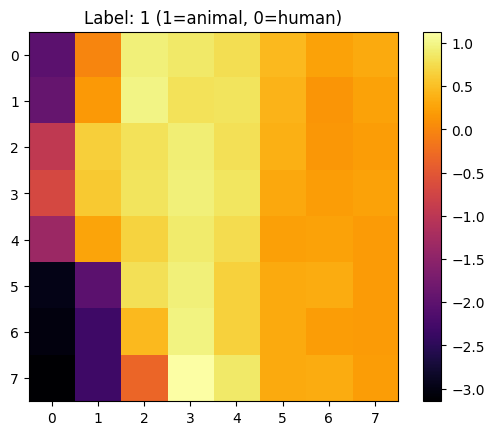

In [8]:
# %%
thermal, radar, label = next(iter(train_loader))
plt.imshow(thermal[0][1], cmap="inferno")
plt.title(f"Label: {label[0].item()} (1=animal, 0=human)")
plt.colorbar()
plt.show()
